# ASC Project 
Research Question Two: Is There a Significant Change in Temperature After the Volcanic Events?

# Import and Set up the Ensemble Data, and Specify the 22 Volcanic Years

In [80]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.signal as signal
plt.style.use('ggplot')

### LOAD DATA

# Load LMR global-mean data
gmt_ensemble_file = np.load('/Users/Stephanie_Zhang/Desktop/ASC_Project/LMR/data/gmt_ensemble_alliters.npz')
tr            = gmt_ensemble_file['recon_times']   # Years
gmt_ensemble  = gmt_ensemble_file['gmt_ensemble']  # Global-mean temperature anomalies
nhmt_ensemble = gmt_ensemble_file['nhmt_ensemble']
shmt_ensemble = gmt_ensemble_file['shmt_ensemble']

# Load volcanic data
volcanic_data = np.loadtxt('/Users/Stephanie_Zhang/Desktop/ASC_Project/LMR/data/volcanic.csv',skiprows=1)
volcanic_years = np.arange(1,2001)
volcanoes = np.stack((volcanic_years,volcanic_data),axis=1)

### CALCULATIONS

# Reshape the array so that ensemble members and iterations are on the same axis
nyears = len(tr)
nens  = gmt_ensemble.shape[1]
niter = gmt_ensemble.shape[2]
gmt  = np.reshape(gmt_ensemble,(nyears,nens*niter))    
nhmt = np.reshape(nhmt_ensemble,(nyears,nens*niter))
shmt = np.reshape(shmt_ensemble,(nyears,nens*niter))

# Compute means of all iterations & ensemble members
gmt_mean  = np.mean(gmt,axis=1)
nhmt_mean = np.mean(nhmt,axis=1)
shmt_mean = np.mean(shmt,axis=1)

# Find the largest 40 volcanic eruptions.
n_events = 22
# extreme_index = volcanic_data.argsort()[-n_events:][::-1]
# extreme_years = volcanic_years[extreme_index]
extreme_years = [169,266,433,536,540,574,626,682,939,1109,1171,1230,1257,1286,1345,1458,1600,1641,1695,1784,1809,1815]


# Define the SEA Method that Removes a 5-year Average

In [81]:
# Find the indices of the temperature data which correspond to the volcano years.
# tr_ex = [tr.tolist().index(year) for year in extreme_years]
tr_ex = extreme_years

# define SEA function
def sea(X, events, w):
#     "Applies superposed Epoch Analysis to timeseries X, at times 'events', and on a window [-w,w]"
    n_events = len(events)
    mat = np.empty([n_events, 4*w+1])
    delta = np.empty(n_events)
    # exception handling : the first extreme year must not happen within the first w years of X
    for i in range(n_events):
        mat[i,:] = X[events[i]-w:events[i]+3*w+1] # select window
        #mat[i,:] = X[events[i]-w-1:events[i]+3*w] # select window
        mat[i,:] -= np.mean(mat[i,0:w]) # remove mean over first half of window
        delta[i] = np.mean(mat[i,w:4*w+1]) - np.mean(mat[i,0:w])
    return mat, delta

# 1. Apply the SEA Method to remove the Average of 5-Year ahead of the Volcanic Events

In [82]:
# apply SEA function to 1 column
w = 5  # windown length (years)
erup, delta = sea(gmt_mean,tr_ex,w)
erup_mean = np.mean(erup,axis=0)
erup_pct  = np.percentile(erup,(5,95),axis=0).T

lags = np.arange(-w,3*w+1); n_lags = len(lags)

"""
#plot the result
fig, ax = plt.subplots(1, 1)
#ax.fill_between(lags,erup_pct[:,0],erup_pct[:,1],alpha=0.3,label='90% HDR')
ax.plot(lags,erup_mean,label='40-eruption composite')
ax.set_xlabel('Time after eruption (years)')    
ax.set_ylabel('GMT response (K)')
ax.set_title('Superposed Epoch Analysis in ensemble member #1')
ax.legend()
fig.savefig('SEA_1member.pdf')
"""

# loop over ensemble members
n_ens = np.shape(gmt)[1]
ens_erup = np.empty([n_events,n_lags,n_ens])
ens_delta = np.empty([n_events,n_ens])


for k in range(n_ens):
    ens_erup[:,:,k], ens_delta[:,k]  = sea(gmt[:,k],tr_ex,w)

# reshape the matrix
erup_avg = np.mean(ens_erup,axis=0)
delta_avg = np.mean(ens_delta,axis=0)
erup_mean = np.mean(erup_avg,axis=1)
erup_pct  = np.percentile(erup_avg,(2.5,97.5),axis=1).T


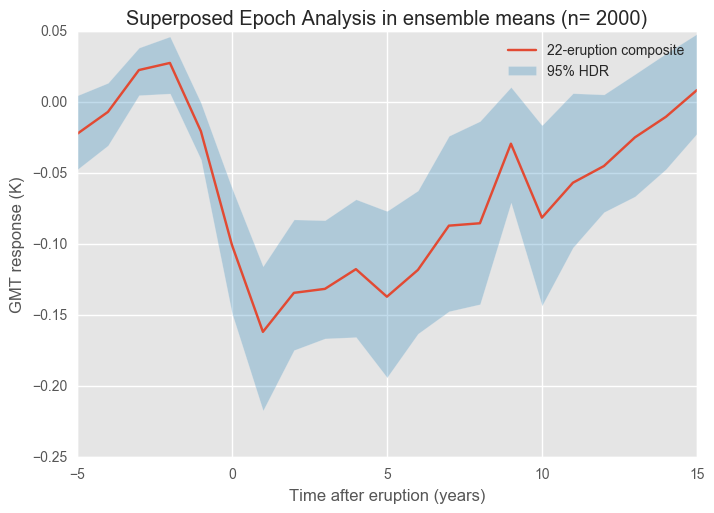

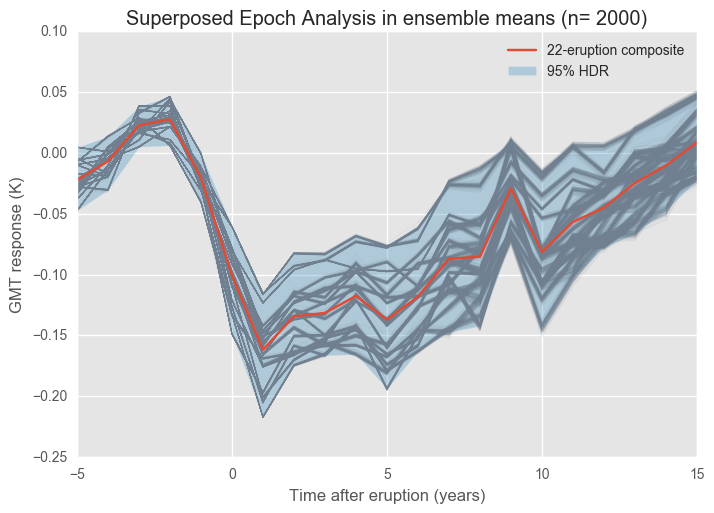

In [83]:
#plot the result
fig2, ax2 = plt.subplots(1, 1)
ax2.fill_between(lags,erup_pct[:,0],erup_pct[:,1],alpha=0.3,label='95% HDR')
ax2.plot(lags,erup_mean,label='22-eruption composite')
ax2.set_xlabel('Time after eruption (years)')    
ax2.set_ylabel('GMT response (K)')
ax2.legend()
ax2.set_title('Superposed Epoch Analysis in ensemble means (n= 2000)')
#fig2.savefig('mpe_SEA_ensAvg.pdf')

fig2, ax2 = plt.subplots(1, 1)
ax2.fill_between(lags,erup_pct[:,0],erup_pct[:,1],alpha=0.3,label='95% HDR')
ax2.plot(lags,erup_avg,color='SlateGray',linewidth=0.5,alpha=.1)
ax2.plot(lags,erup_mean,label='22-eruption composite')
ax2.set_xlabel('Time after eruption (years)')    
ax2.set_ylabel('GMT response (K)')
ax2.legend()
ax2.set_title('Superposed Epoch Analysis in ensemble means (n= 2000)')
plt.show()
#fig2.savefig('mpe_SEA_ensAvg_individual.pdf')

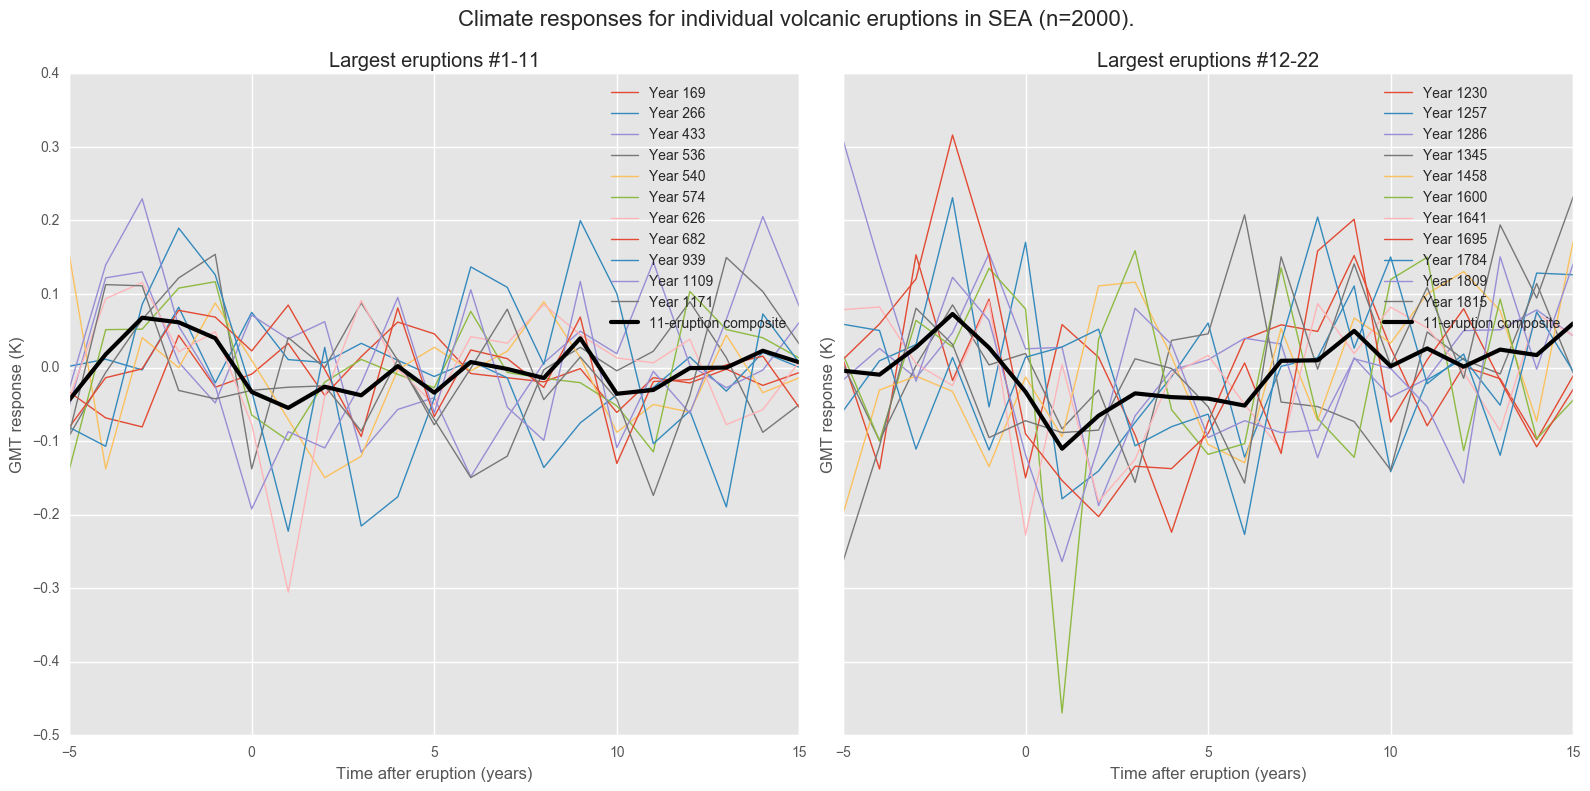

In [102]:
# Plot the responses to the 22 individual eruptions.
ind_erup = np.mean(ens_erup,axis=2)
ind_erup = np.swapaxes(ind_erup,0,1)

#plt.style.use('seaborn-colorblind')
#plt.style.use('classic')
plt.style.use('ggplot')
f, ax = plt.subplots(1,2,figsize=(16,8),sharex=True,sharey=True)
ax = ax.ravel()
for i in range(2):
    ax[i].set_title("Largest eruptions #"+str(i*11+1)+"-"+str((i+1)*11))
    selected_erup = ind_erup[:,i*11:(i+1)*11]
    for counter in range(11): ax[i].plot(lags,selected_erup[:,counter],label="Year "+str(extreme_years[i*11+counter]),linewidth=1)
    #
    ax[i].plot(lags,np.mean(selected_erup,axis=1),label='11-eruption composite',linewidth=3,color='k')
    ax[i].set_xlabel('Time after eruption (years)')    
    ax[i].set_ylabel('GMT response (K)')
    ax[i].legend()

f.suptitle("Climate responses for individual volcanic eruptions in SEA (n=2000).",fontsize=16)
f.tight_layout()
f.subplots_adjust(top=.9)
#plt.savefig("figures/mpe_SEA_individual_eruptions.jpg")
plt.show()

# 2. Try a High-Pass Filter then with a 5-Year Average Removal when doing SEA

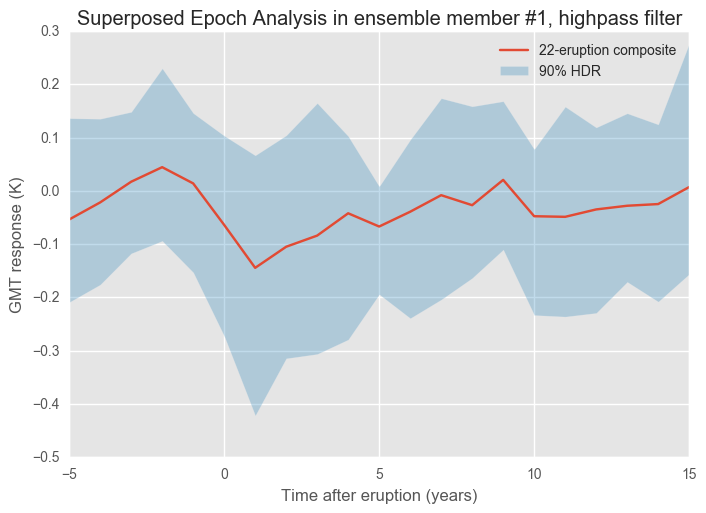

In [85]:
# apply high-pass filter

def highpass(X,Tc):
    "Applies high-pass filter (cutoff period Tc) to timeseries X; returns Xhp"
    fc = 1/np.float(Tc)  # Cutoff frequency as a fraction of the sampling rate (in (0, 0.5)).
    b = 0.08  # Transition band, as a fraction of the sampling rate (in (0, 0.5)).
    N = int(np.ceil((4 / b)))
    if not N % 2: N += 1  # Make sure that N is odd.
    n = np.arange(N)
    # Compute sinc filter.
    h = np.sinc(2 * fc * (n - (N - 1) / 2.))
    # Compute Blackman window.
    w = 0.42 - 0.5 * np.cos(2 * np.pi * n / (N - 1)) +         0.08 * np.cos(4 * np.pi * n / (N - 1))
    # Multiply sinc filter with window.
    h = h * w
    # Normalize to get unity gain.
    h = h / np.sum(h)
    # Smooth the dataset
    Xlp = np.convolve(X,h,'same')
    Xhp = X - Xlp
    return Xhp



# apply HP filter to gmt --> gmt_hp

# apl=pky same analysis to gmt_hp --> Is there a difference?
erup,delta = sea(highpass(gmt[:,1],n_lags),extreme_years,w)
# erup = list(erup)
erup_mean = np.mean(erup,axis=0)
erup_pct  = np.percentile(erup,(5,95),axis=0).T

#plot the result

fig3, ax3 = plt.subplots(1, 1)
ax3.fill_between(lags,erup_pct[:,0],erup_pct[:,1],alpha=0.3,label='90% HDR')
ax3.plot(lags,erup_mean,label='22-eruption composite')
ax3.set_xlabel('Time after eruption (years)')    
ax3.set_ylabel('GMT response (K)')
ax3.set_title('Superposed Epoch Analysis in ensemble member #1, highpass filter')
ax3.legend()
plt.show()
# fig.savefig('SEA_1member_highpass.pdf')

In [86]:
for k in range(n_ens):
    ens_erup[:,:,k], ens_delta[:,k]  = sea(highpass(gmt[:,k], n_lags),tr_ex,w)
erup_avg = np.mean(ens_erup,axis=0)
delta_avg = np.mean(ens_delta,axis=0)
erup_mean = np.mean(erup_avg,axis=1)
erup_pct  = np.percentile(erup_avg,(2.5,97.5),axis=1).T


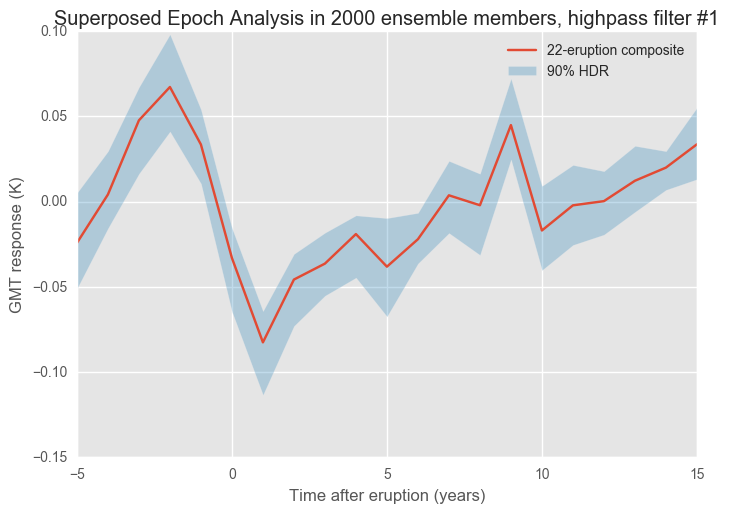

In [104]:
fig3, ax3 = plt.subplots(1, 1)
ax3.fill_between(lags,erup_pct[:,0],erup_pct[:,1],alpha=0.3,label='90% HDR')
ax3.plot(lags,erup_mean,label='22-eruption composite')
ax3.set_xlabel('Time after eruption (years)')    
ax3.set_ylabel('GMT response (K)')
ax3.set_title('Superposed Epoch Analysis in 2000 ensemble members, highpass filter #1')
ax3.legend()
plt.show()

# 3. Apply the HighPassFilter2 then with a 5-Year Average Removal when doing SEA

In [105]:
def highpass2(X):
    f_low = 1/10
    b, a = signal.butter(4, f_low)
    gmt_lowF = np.empty(X.shape)
    gmt_lowF = signal.filtfilt(b, a, X)
    gmt_highF = X - gmt_lowF
    return gmt_highF

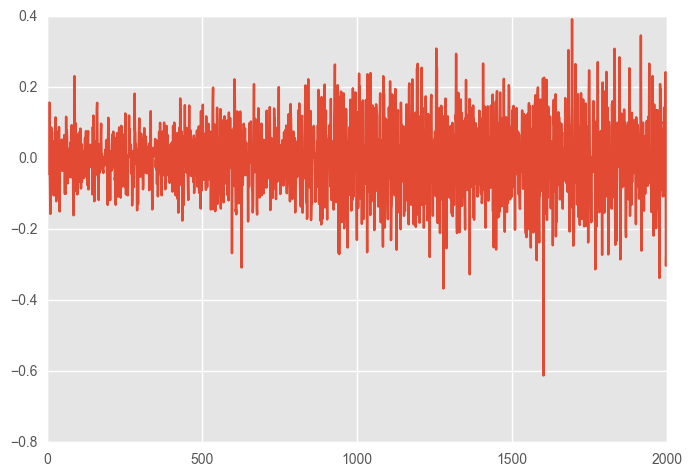

In [106]:
filtered = highpass2(gmt[:,1])
plt.plot(filtered)
plt.show()

In [107]:
for k in range(n_ens):
    ens_erup[:,:,k], ens_delta[:,k]  = sea(highpass2(gmt[:,k]),tr_ex,w)
erup_avg = np.mean(ens_erup,axis=0)
delta_avg = np.mean(ens_delta,axis=0)
erup_mean = np.mean(erup_avg,axis=1)
erup_pct  = np.percentile(erup_avg,(2.5,97.5),axis=1).T

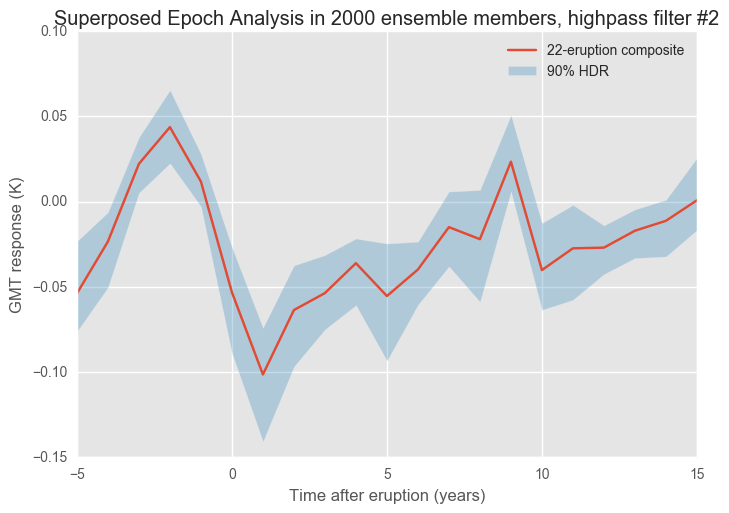

In [108]:
fig3, ax3 = plt.subplots(1, 1)
ax3.fill_between(lags,erup_pct[:,0],erup_pct[:,1],alpha=0.3,label='90% HDR')
ax3.plot(lags,erup_mean,label='22-eruption composite')
ax3.set_xlabel('Time after eruption (years)')    
ax3.set_ylabel('GMT response (K)')
ax3.set_title('Superposed Epoch Analysis in 2000 ensemble members, highpass filter #2')
ax3.legend()
plt.show()

# 4. Apply the HighPass Filter (without subtracting 5-year mean before erruption) when doing the SEA

In [109]:
tr_ex = [tr.tolist().index(year) for year in extreme_years]

# define SEA function
def sea2(X, events, w):
#     "Applies superposed Epoch Analysis to timeseries X, at times 'events', and on a window [-w,w]"
    n_events = len(events)
    mat = np.empty([n_events, 4*w+1])
    delta = np.empty(n_events)
    # exception handling : the first extreme year must not happen within the first w years of X
    for i in range(n_events):
        mat[i,:] = X[events[i]-w:events[i]+3*w+1] # select window
        #mat[i,:] = X[events[i]-w-1:events[i]+3*w] # select window
#         mat[i,:] -= np.mean(mat[i,0:w]) # remove mean over first half of window
        delta[i] = np.mean(mat[i,w:4*w+1]) - np.mean(mat[i,0:w])
    return mat, delta


In [110]:
for k in range(n_ens):
    ens_erup[:,:,k], ens_delta[:,k]  = sea2(highpass(gmt[:,k], n_lags),tr_ex,w)
erup_avg = np.mean(ens_erup,axis=0)
delta_avg = np.mean(ens_delta,axis=0)
erup_mean = np.mean(erup_avg,axis=1)
erup_pct  = np.percentile(erup_avg,(2.5,97.5),axis=1).T

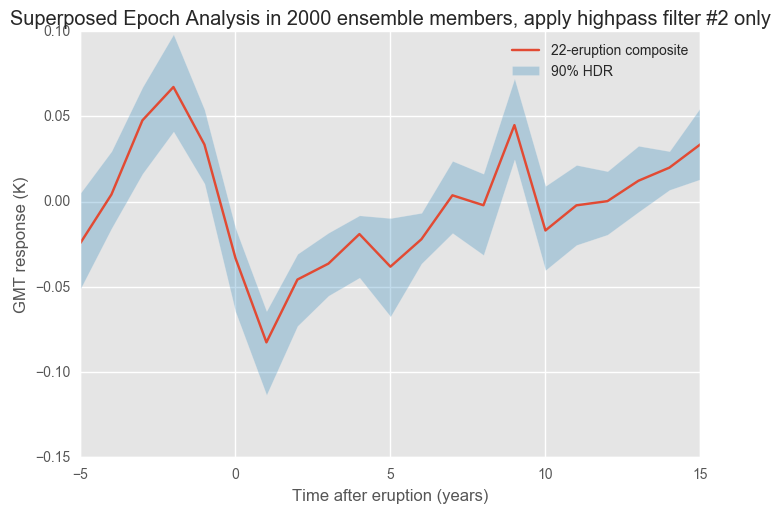

In [111]:
fig5, ax5 = plt.subplots(1, 1)
ax5.fill_between(lags,erup_pct[:,0],erup_pct[:,1],alpha=0.3,label='90% HDR')
ax5.plot(lags,erup_mean,label='22-eruption composite')
ax5.set_xlabel('Time after eruption (years)')    
ax5.set_ylabel('GMT response (K)')
ax5.set_title('Superposed Epoch Analysis in 2000 ensemble members, apply highpass filter #2 only')
ax5.legend()
plt.show()